<a href="https://colab.research.google.com/github/Luzinsan/OPD_neuro/blob/main/Practice1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Подготовка входных данных***

In [291]:
!ls

ecoli  ecoli.zip  sample_data


In [292]:
!unzip "ecoli.zip" -d "ecoli"

Archive:  ecoli.zip
replace ecoli/ecoli.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [293]:
def load_keel(file_path):
    file_path = Path(file_path)
    return KeelParser()(file_path.read_text())

In [294]:
import re
from pathlib import Path
from pandas import DataFrame, Categorical, to_numeric
import numpy as np
from functools import partial
from sklearn.preprocessing import LabelEncoder

class DataScheme:
    def __init__(self, data_name, attributes, inputs, outputs, X, y):
        self.data_name = data_name
        self.inputs = inputs
        self.outputs = outputs
        self.attributes = attributes
        self.X = X
        self.y = y



class KeelParser:
    def __call__(self, data):
        self.data = data

        data_name = self.get_data_name()
        attributes = self.get_attributes()
        inputs = self.get_inputs()
        outputs = self.get_outputs()
        data_frame = self.get_data()
        data_frame.columns = [*inputs, *outputs]
        X = np.array(data_frame[inputs])
        y = np.array(data_frame[outputs]).ravel()

        if len(outputs) > 1:
            raise Exception('Multiple outputs in dataset not yet supported')
        if attributes[outputs[0]][0] == 'nominal':
            y = Categorical(
                y,
                ordered=False,
                categories=attributes[outputs[0]][1]
            ).codes
        elif attributes[outputs[0]][0] == 'real':
            y = np.array(y, dtype=float)
        return DataScheme(data_name, attributes, inputs, outputs, X, y)

    def get_data_name(self):
        """
        Функция для получения названия набора данных
        :return:
        """
        parsed = re.search(r'^@relation\s+(\S+)$', self.data, re.MULTILINE)
        return parsed.group(1)

    def get_attributes(self):
        """
        Функция для получения описаний входных и выходных параметров
        набора данных
        :return:
        """
        attributes = dict()
        if "Attribute" in self.data:
            parsed = re.findall(r'^@Attribute\s+(.+)$', self.data,
                                re.MULTILINE)
        else:
            parsed = re.findall(r'^@attribute\s+(.+)$', self.data,
                                re.MULTILINE)

        for att in parsed:
            if '{' in att:
                name = att[:att.index('{')].strip()
                att = att[att.index('{'):]
                for char in '{}':
                    att = att.replace(char, '')
                att = att.replace(" ", "")
                att = att.split(',')
                attributes[name] = ['nominal', att]
            else:
                if 'real' in att or 'integer' in att:
                    name = att[:att.index(' ')]
                    att = att[att.index(' ') + 1:]
                    att_type = att[:att.index('[')].strip()
                    att = att[att.index('['):]
                    for char in '[]':
                        att = att.replace(char, '')
                    attributes[name] = [
                        att_type, att.replace(' ', '').split(',')]
                else:
                    if 'numeric' in att:
                        att = att.split(' ')
                        attributes[att[0].strip()] = ['numeric']
                    else:
                        raise Exception(
                            f'Error during @attribute line parse: {att}')

        return attributes

    def get_inputs(self):
        """
        Функция для получения списка входных параметров набора данных
        :return:
        """
        parsed = re.search(r'^@inputs\s+(.+)$', self.data, re.MULTILINE)
        return [j.strip() for j in parsed.group(1).split(',')]

    def get_outputs(self):
        """
        Функция для получения списка выходных меток набора данных
        :return:
        """
        if "outputs" in self.data:
            parsed = re.search(r'^@outputs\s+(.+)$', self.data, re.MULTILINE)
        else:
            parsed = re.search(r'^@output\s+(.+)$', self.data, re.MULTILINE)

        return [x.strip() for x in parsed.group(1).split(',')]

    def get_data(self):
        """
        Функция для получения данных из выбранного набора
        :return:
        """
        parsed = re.search(
            r'^@data\n(.+)', self.data, flags=re.MULTILINE | re.DOTALL)
        data = np.array([
            re.split(r', ?', item) for item in parsed.group(1).splitlines()])
        dim = len(data[0])
        ys = np.copy(data[:, dim - 1])
        data[:, dim - 1] = 0
        df = DataFrame(data=data)
        df = df.apply(partial(to_numeric, errors='ignore'))
        if not (df.select_dtypes(['object']).empty):
            df.loc[:, df.dtypes == 'object'] = df.select_dtypes([
                'object'
            ]).apply(lambda x:
                     (LabelEncoder().fit_transform(x)).astype('float'))
        df[dim - 1] = df[dim - 1].astype(str)
        df[dim - 1] = ys

        return df

In [295]:
import os

FILE_PATH = '/content/ecoli'
MAIN_FILE_NAME = 'ecoli.dat'

data = load_keel('/content/ecoli/ecoli.dat')

ecoli = data

In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

In [297]:
import tensorflow as tf

# ***Решение задачи регрессии***

In [298]:
#Определение функции, создающей модель-регрессор
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  # Большинство tf.keras моделей представляют собой простую последовательность слоев -
  # sequential.
  model = tf.keras.models.Sequential()

  # Описание архитектуры модели
  model.add(tf.keras.layers.Dense(units=1, 
                                  input_shape=(1,)))

  # Компиляция модели
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model           

print("Defined create_model")


Defined create_model


In [299]:
def train_model(model, feature, label, epochs, batch_size):
  """Train the model by feeding it data."""

  # Задание параметров обучения и запуск обучения
  history = model.fit(x=feature,
                      y=label,
                      batch_size=batch_size,
                      epochs=epochs)

  # Получения параметров модели - линейного слоя
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  epochs = history.epoch
  
  hist = pd.DataFrame(history.history)

  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse

print("Defined ctrain_model")

Defined ctrain_model


In [300]:
def plot_the_loss_curve(epochs, rmse):
  """График лосс-значений/эпохи"""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


Определяем X, y (my_feature, label)

In [301]:
my_feature = ([1.0, 2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0, 11.0, 12.0])
my_label   = ([5.0, 8.8,  9.6, 14.2, 18.8, 19.5, 21.4, 26.8, 28.9, 32.0, 33.8, 38.2])

In [302]:
learning_rate=0.15
epochs=40
my_batch_size=12

my_model = build_model(learning_rate)
trained_weight, trained_bias, epochs, rmse = train_model(my_model, my_feature, 
                                                         my_label, epochs,
                                                         my_batch_size)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


1/1 [==============================] - 0s 295ms/step - loss: 503.4810 - root_mean_squared_error: 22.4384
Epoch 2/40
1/1 [==============================] - 0s 6ms/step - loss: 343.2309 - root_mean_squared_error: 18.5265
Epoch 3/40
1/1 [==============================] - 0s 5ms/step - loss: 254.7260 - root_mean_squared_error: 15.9601
Epoch 4/40
1/1 [==============================] - 0s 7ms/step - loss: 194.8823 - root_mean_squared_error: 13.9600
Epoch 5/40
1/1 [==============================] - 0s 5ms/step - loss: 151.1450 - root_mean_squared_error: 12.2941
Epoch 6/40
1/1 [==============================] - 0s 6ms/step - loss: 117.9013 - root_mean_squared_error: 10.8582
Epoch 7/40
1/1 [==============================] - 0s 13ms/step - loss: 92.0806 - root_mean_squared_error: 9.5959
Epoch 8/40
1/1 [==============================] - 0s 14ms/step - loss: 71.7850 - root_mean_squared_error: 8.4726
Epoch 9/40
1/1 [==============================] - 0s 6ms/step - loss: 55.7409 - root_mean_squared_e

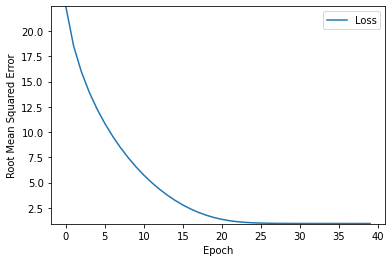

In [303]:
plot_the_loss_curve(epochs, rmse)

# ***Решение задачи классификации***

In [304]:
# Генерация названий строк
ecoli_names = np.array(['Ecoli{}'.format(i) for i in range(data.X.shape[0])])

In [305]:
data = pd.DataFrame(data.X, columns=data.inputs, index=ecoli_names)
data

,Mcg,Gvh,Lip,Chg,Aac,Alm1,Alm2
Ecoli0,49.0,29.0,48.0,5.0,56.0,24.0,35.0
Ecoli1,7.0,4.0,48.0,5.0,54.0,35.0,44.0
Ecoli2,56.0,4.0,48.0,5.0,49.0,37.0,46.0
Ecoli3,59.0,49.0,48.0,5.0,52.0,45.0,36.0
Ecoli4,23.0,32.0,48.0,5.0,55.0,25.0,35.0
...,...,...,...,...,...,...,...
Ecoli331,74.0,56.0,48.0,5.0,47.0,68.0,3.0
Ecoli332,71.0,57.0,48.0,5.0,48.0,35.0,32.0
Ecoli333,61.0,6.0,48.0,5.0,44.0,39.0,38.0
Ecoli334,59.0,61.0,48.0,5.0,42.0,42.0,37.0


*Теперь нормализуем данные*

In [306]:
from sklearn.preprocessing import MinMaxScaler

In [307]:
data_scaled = MinMaxScaler().fit_transform(data)

In [308]:
pd.DataFrame(data_scaled, columns=ecoli.inputs, index=ecoli_names)

,Mcg,Gvh,Lip,Chg,Aac,Alm1,Alm2
Ecoli0,0.550562,0.321839,1.0,1.0,0.636364,0.247312,0.353535
Ecoli1,0.078652,0.034483,1.0,1.0,0.613636,0.365591,0.444444
Ecoli2,0.629213,0.034483,1.0,1.0,0.556818,0.387097,0.464646
Ecoli3,0.662921,0.551724,1.0,1.0,0.590909,0.473118,0.363636
Ecoli4,0.258427,0.356322,1.0,1.0,0.625000,0.258065,0.353535
...,...,...,...,...,...,...,...
Ecoli331,0.831461,0.632184,1.0,1.0,0.534091,0.720430,0.030303
Ecoli332,0.797753,0.643678,1.0,1.0,0.545455,0.365591,0.323232
Ecoli333,0.685393,0.057471,1.0,1.0,0.500000,0.408602,0.383838
Ecoli334,0.662921,0.689655,1.0,1.0,0.477273,0.440860,0.373737


In [309]:
def build_model(my_learning_rate):
  """Создание классификатора"""
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Dense(units=8, 
                                  input_shape=(7,)))
  # Выходной слой с числом нейронов по числу классов
  model.add(tf.keras.layers.Dense(30))
  model.add(tf.keras.layers.Dense(8))

  # Лосс-функция уже другая 
  model.compile(optimizer=tf.optimizers.Adam(lr=my_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model  

print("Defined create_model")

Defined create_model


In [310]:
def train_model(model, feature, label, epochs, batch_size):
  """Обучение модели"""

  history = model.fit(x=feature,
                      y=label,
                      batch_size=batch_size,
                      epochs=epochs)

  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  epochs = history.epoch

  hist = pd.DataFrame(history.history)

  acc = hist["accuracy"]

  return trained_weight, trained_bias, epochs, acc

print("Defined train_model")

Defined train_model


In [311]:
def plot_the_loss_curve(epochs, acc):
  """График лосс-значений/эпохи"""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Sparse Categorical Crossentropy ")

  plt.plot(epochs, acc, label="Accuracy")
  plt.legend()
  plt.ylim([acc.min()*0.97, acc.max()])
  plt.show()

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


In [312]:
x = data_scaled
y = ecoli.y

In [323]:
learning_rate=0.001
epochs=300
my_batch_size= 15

my_model = build_model(learning_rate)
trained_weight, trained_bias, epochs, acc = train_model(my_model, x, 
                                                        y, epochs,
                                                        my_batch_size)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/300
23/23 [==============================] - 0s 2ms/step - loss: 1.9700 - accuracy: 0.2202
Epoch 2/300
23/23 [==============================] - 0s 1ms/step - loss: 1.6542 - accuracy: 0.4345
Epoch 3/300
23/23 [==============================] - 0s 1ms/step - loss: 1.4824 - accuracy: 0.4732
Epoch 4/300
23/23 [==============================] - 0s 2ms/step - loss: 1.3934 - accuracy: 0.5119
Epoch 5/300
23/23 [==============================] - 0s 1ms/step - loss: 1.3367 - accuracy: 0.5565
Epoch 6/300
23/23 [==============================] - 0s 2ms/step - loss: 1.2859 - accuracy: 0.5744
Epoch 7/300
23/23 [==============================] - 0s 2ms/step - loss: 1.2447 - accuracy: 0.5804
Epoch 8/300
23/23 [==============================] - 0s 1ms/step - loss: 1.2041 - accuracy: 0.5804
Epoch 9/300
23/23 [==============================] - 0s 1ms/step - loss: 1.1687 - accuracy: 0.5893
Epoch 10/300
23/23 [==============================] - 0s 1ms/step - loss: 1.1331 - accuracy: 0.6339
Epoch 11/

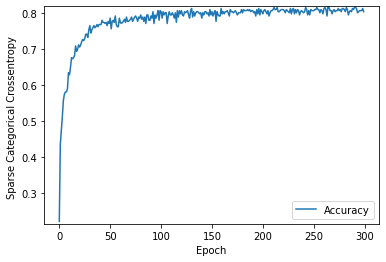

In [324]:
plot_the_loss_curve(epochs, acc)

In [315]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
dataset = fetch_openml('har')
X = StandardScaler().fit_transform(dataset.data)
Y = dataset.target
Y_new = []
for i in range(len(Y)):
  Y_new.append(int(Y[i]))

In [316]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

In [317]:
from sklearn.model_selection import train_test_split
features = X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(
    X[:, :features], 
    Y, 
    test_size=0.3, 
    shuffle=True)

In [325]:
kf = KFold(n_splits=5)
accs = []
for train_index, test_index in kf.split(X):
  for i in range(0, 5):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model = LinearSVC(tol=1e1)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    acc = accuracy_score(predicted, y_test)
    accs.append(acc)
print(np.mean(accs))

0.9376839261211729
